# load datasets and Pre Processing 

In [1]:
from torchvision.transforms import ToTensor, Resize
import torch
import torch.nn as nn
# import torchtext
from torchvision.transforms import ToTensor, Resize, Compose
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import PIL 
import os
import pandas as pd
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import glob
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm


## Pre-Processing

In [4]:
all_poems_path = glob.glob("Persian_poems_corpus/normalized/*.txt")
pathes = random.sample(all_poems_path, k=10)
poet_name = [name.split("/")[-1].split("_")[0] for name in pathes]
print("10 random poet names :", poet_name)

10 random poet names : ['khajoo', 'feyz', 'parvin', 'attar', 'seyf', 'khosro', 'farrokhi', 'amir', 'shahriar', 'naserkhosro']


In [5]:
import csv
char_remov = ['\n', '\t']
with open('poems.csv', 'w', encoding='utf-8') as data:
    w = csv.writer(data)
    for path in pathes:
        with open(path, 'r') as poem:
            for sen in poem.readlines():
                for char in char_remov:
                    sen = sen.replace(char, '')
                if sen != '':
                    w.writerow([sen, pathes.index(path)])

In [6]:
df = pd.read_csv('poems.csv', encoding='utf-8').dropna()
df.columns = ['text' , 'label']
df

,text,label
0,ای غره ماه از اثر صنع تو غرا,0
1,وی طره شب از دم لطف تو مطرا,0
2,نوک قلم صنع تودر مبدا فطرت,0
3,انگیخته برصفحه کن صورت اشیا,0
4,سجاده نشینان نه ایوان فلک را,0
...,...,...
397543,رنج و عنای جهان اگرچه درازست,9
397544,با بد و با نیک بی گمان به سرآید,9
397545,چون مسافر زبهر ماست شب و روز,9
397546,هرچه یکی رفت بر اثر دگر آید,9


In [7]:
x = []
for i in range(10):
    x.append(sum(df['label'] == i))
weight = torch.tensor(x)
f = weight/sum(weight)
weight = sum(weight)/(10*f)
weight = weight/sum(weight)

In [8]:
train, test = train_test_split(df, train_size=0.8)

In [9]:
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenize_train = tokenizer(train['text'].tolist(), truncation=True, padding=True, max_length=256)
tokenize_test = tokenizer(test['text'].tolist(), truncation=True, padding=True, max_length=256)

# Part 1: train FC of model

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:
import torch 
from torch.utils.data import Dataset
from transformers import AutoModel
from torch.utils.data import Dataset, DataLoader, random_split


class PoemDataset(Dataset):
    def __init__(self, encode, label):
        self.encode = encode
        self.label = label

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encode['input_ids'][idx])
        token_type_ids = torch.tensor(self.encode['token_type_ids'][idx])
        attention_mask = torch.tensor(self.encode['attention_mask'][idx])
        label = torch.tensor(self.label[idx])
        return input_ids,token_type_ids,attention_mask,label

    def __len__(self):
        return len(self.label)

class PoemNetwork(nn.Module):
  def __init__(self):
    super(PoemNetwork, self).__init__()
    self.bert = AutoModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
    self.fc = nn.Linear(768, 32)
    self.fc2 = nn.Linear(32, 10)
  
  def forward(self, input_ids, attention_mask):
    bert_model = self.bert(input_ids, attention_mask=attention_mask)[1]
    y = self.fc(bert_model)
    y = self.fc2(y)
    return y

In [12]:
training_dataset = PoemDataset(tokenize_train, train['label'].tolist())
test_dataset = PoemDataset(tokenize_test, test['label'].tolist())

In [13]:
batchSize = 64

train_dataloader = DataLoader(training_dataset, batch_size=batchSize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchSize, shuffle=True)

In [14]:
model = PoemNetwork()
model.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PoemNetwork(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [15]:
for param in model.bert.parameters():
    param.requires_grad = False

In [16]:
learning_rate = 1e-3

# loss_fn = nn.BCEWithLogitsLoss(weight = weight.to(device))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
from tqdm import tqdm
def train_loop(epoch, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avgLoss = 0
    avgCorrect = 0
    model.train()
    with tqdm(dataloader, unit="batch") as tepoch:
        for  (X, token, mask, label) in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            
            # Compute prediction and loss
            size_batch = X.shape[0]

            X = X.to(device)
            mask = mask.to(device)
            label = label.to(device)
            # label = nn.functional.one_hot(label, num_classes=10).to(torch.float).reshape((-1,10))
            pred = model(X, attention_mask=mask)

            loss = loss_fn(pred, label)
            avgLoss += loss.item()
            correct = (pred.argmax(1) == label).type(torch.float).sum().item()
            # correct = torch.sum(torch.argmax(label,dim=1) == torch.argmax(pred,dim=1))
            avgCorrect += correct
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            correct = correct / size_batch
            
            tepoch.set_postfix(batch_loss=loss.item(), batch_accuracy=100. * correct)
            
    avgLoss /= len(dataloader)
    avgCorrect = avgCorrect / size
    print(f" -Training Accuracy (Avg) = {(100*avgCorrect):>0.1f}%, loss = {avgLoss:>8f} \n")
    return avgCorrect, avgLoss

def test_loop(dataloader, model, loss_fn, error):
    size = len(dataloader.dataset)
    avgLoss = 0
    avgCorrect = 0
    model.eval()
    with torch.no_grad():
        for  (X, token, mask, label) in dataloader:
            # Compute prediction and loss
            X = X.to(device)
            mask = mask.to(device)
            label = label.to(device)
            # label = nn.functional.one_hot(label, num_classes=10).to(torch.float).reshape((-1,10))
            pred = model(input_ids=X, attention_mask=mask)

            avgLoss += loss_fn(pred, label).item()
            avgCorrect += (pred.argmax(1) == label).type(torch.float).sum().item()
            # avgCorrect += torch.sum(torch.argmax(label,dim=1) == torch.argmax(pred,dim=1))

    avgLoss /= len(dataloader)
    avgCorrect = avgCorrect / size
    print(f" -{error} : Accuracy = {(100*avgCorrect):>0.1f}%, Avg loss = {avgLoss:>8f} \n")
    return avgCorrect, avgLoss

In [18]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(log_dir='MLP_Board')

epochs = 5
for e in range(epochs):
    print(f" Epoch {e+1} -------------------------------")
    trainAcc, trainLoss = train_loop(e, train_dataloader, model, loss_fn, optimizer)
    # writer.add_scalar('Accuracy/train', trainAcc, e)
    # writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(test_dataloader, model, loss_fn, 'Test')
    # writer.add_scalar('Accuracy/validation', valAcc, e)
    # writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

 Epoch 1 -------------------------------


Epoch 1: 100%|██████████| 4970/4970 [01:39<00:00, 50.14batch/s, batch_accuracy=45.5, batch_loss=1.46] 


 -Training Accuracy (Avg) = 49.6%, loss = 1.590678 

 -Test : Accuracy = 51.0%, Avg loss = 1.527501 

 Epoch 2 -------------------------------


Epoch 2: 100%|██████████| 4970/4970 [01:40<00:00, 49.60batch/s, batch_accuracy=50, batch_loss=1.33]  


 -Training Accuracy (Avg) = 50.3%, loss = 1.551409 

 -Test : Accuracy = 51.6%, Avg loss = 1.497403 

 Epoch 3 -------------------------------


Epoch 3: 100%|██████████| 4970/4970 [01:40<00:00, 49.45batch/s, batch_accuracy=54.5, batch_loss=1.28]


 -Training Accuracy (Avg) = 50.6%, loss = 1.539846 

 -Test : Accuracy = 51.7%, Avg loss = 1.484222 

 Epoch 4 -------------------------------


Epoch 4: 100%|██████████| 4970/4970 [01:40<00:00, 49.47batch/s, batch_accuracy=59.1, batch_loss=1.35]


 -Training Accuracy (Avg) = 50.7%, loss = 1.535000 

 -Test : Accuracy = 52.1%, Avg loss = 1.488309 

 Epoch 5 -------------------------------


Epoch 5: 100%|██████████| 4970/4970 [01:40<00:00, 49.54batch/s, batch_accuracy=50, batch_loss=1.65]  


 -Training Accuracy (Avg) = 50.7%, loss = 1.531379 

 -Test : Accuracy = 51.9%, Avg loss = 1.497574 

Done!


In [19]:
y_pred = []
y_true = []

with torch.no_grad():
    for  (X, token, mask, label) in test_dataloader:
        X = X.to(device)
        mask = mask.to(device)
        label = label.to(device)
        pred = model(input_ids=X, attention_mask=mask)
        output = pred.argmax(1).cpu().numpy()
        y_pred.extend(output)
        label = label.cpu().numpy()
        y_true.extend(label)

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [21]:
print(classification_report(y_true=y_true,
                            y_pred=y_pred,
                            target_names=poet_name))

              precision    recall  f1-score   support

      khajoo       0.27      0.12      0.17      3509
        feyz       0.36      0.03      0.05      4019
      parvin       0.46      0.01      0.02      2168
       attar       0.60      0.88      0.71     37937
        seyf       0.31      0.06      0.11      5249
      khosro       0.31      0.32      0.32      9333
    farrokhi       0.32      0.04      0.07      4843
        amir       0.37      0.49      0.42      7415
    shahriar       0.74      0.09      0.16       785
 naserkhosro       0.42      0.05      0.09      4252

    accuracy                           0.52     79510
   macro avg       0.42      0.21      0.21     79510
weighted avg       0.47      0.52      0.44     79510



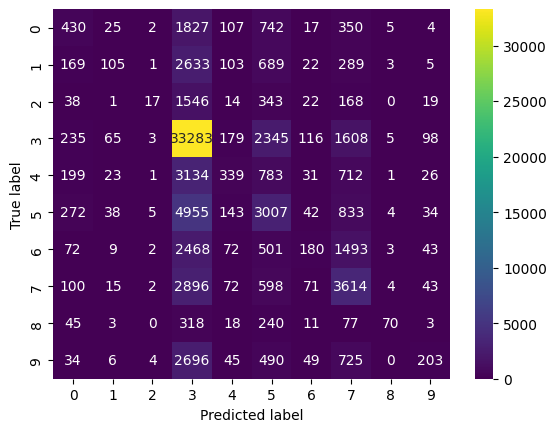

In [22]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Part 2 : Fine-tune Model

توجه ! به دلیل نامتوازن بودن دیتاست ها امکان دارد در هر بار اجرا دقت های متفاوتی بگیریم ولی با افزایش تعداد ایپاک ها می توان این مشکل را حل نمود که به دلیل منابع محاسباتی کم تعداد آن ها را حداقل مقدار یعنی 5 در نظر گرفته شده است 

### Adam optimizer :

In [30]:
model_fineTuned_adam = PoemNetwork()
model_fineTuned_adam.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PoemNetwork(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [31]:
for param in model_fineTuned_adam.bert.parameters():
    param.requires_grad = True

In [32]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(log_dir='MLP_Board')

learning_rate = 2e-5
# loss_fn = nn.BCEWithLogitsLoss(weight = weight.to(device))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fineTuned_adam.parameters(), lr=learning_rate)

epochs = 5
for e in range(epochs):
    print(f" Epoch {e+1} -------------------------------")
    trainAcc, trainLoss = train_loop(e, train_dataloader, model_fineTuned_adam, loss_fn, optimizer)
    # writer.add_scalar('Accuracy/train', trainAcc, e)
    # writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(test_dataloader, model_fineTuned_adam, loss_fn, 'Test')
    # writer.add_scalar('Accuracy/validation', valAcc, e)
    # writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

 Epoch 1 -------------------------------


Epoch 1: 100%|██████████| 4970/4970 [06:20<00:00, 13.06batch/s, batch_accuracy=77.3, batch_loss=0.81] 


 -Training Accuracy (Avg) = 64.1%, loss = 1.097730 

 -Test : Accuracy = 70.3%, Avg loss = 0.888628 

 Epoch 2 -------------------------------


Epoch 2: 100%|██████████| 4970/4970 [06:22<00:00, 12.99batch/s, batch_accuracy=81.8, batch_loss=0.495]


 -Training Accuracy (Avg) = 74.3%, loss = 0.768177 

 -Test : Accuracy = 73.7%, Avg loss = 0.789240 

 Epoch 3 -------------------------------


Epoch 3: 100%|██████████| 4970/4970 [06:23<00:00, 12.97batch/s, batch_accuracy=81.8, batch_loss=0.567]


 -Training Accuracy (Avg) = 80.7%, loss = 0.580073 

 -Test : Accuracy = 75.0%, Avg loss = 0.789007 

 Epoch 4 -------------------------------


Epoch 4: 100%|██████████| 4970/4970 [06:22<00:00, 12.98batch/s, batch_accuracy=86.4, batch_loss=0.38] 


 -Training Accuracy (Avg) = 85.8%, loss = 0.426460 

 -Test : Accuracy = 75.9%, Avg loss = 0.782348 

 Epoch 5 -------------------------------


Epoch 5: 100%|██████████| 4970/4970 [06:22<00:00, 12.98batch/s, batch_accuracy=81.8, batch_loss=0.447] 


 -Training Accuracy (Avg) = 89.7%, loss = 0.307256 

 -Test : Accuracy = 76.3%, Avg loss = 0.863269 

Done!


In [33]:
y_pred = []
y_true = []

with torch.no_grad():
    for  (X, token, mask, label) in test_dataloader:
        X = X.to(device)
        mask = mask.to(device)
        label = label.to(device)
        pred = model_fineTuned_adam(input_ids=X, attention_mask=mask)
        output = pred.argmax(1).cpu().numpy()
        y_pred.extend(output)
        label = label.cpu().numpy()
        y_true.extend(label)

In [34]:
print(classification_report(y_true=y_true,
                            y_pred=y_pred,
                            target_names=poet_name))

              precision    recall  f1-score   support

      khajoo       0.59      0.59      0.59      3509
        feyz       0.64      0.55      0.59      4019
      parvin       0.52      0.45      0.48      2168
       attar       0.87      0.90      0.89     37937
        seyf       0.73      0.59      0.65      5249
      khosro       0.61      0.67      0.64      9333
    farrokhi       0.71      0.66      0.69      4843
        amir       0.72      0.76      0.74      7415
    shahriar       0.52      0.57      0.54       785
 naserkhosro       0.68      0.58      0.63      4252

    accuracy                           0.76     79510
   macro avg       0.66      0.63      0.64     79510
weighted avg       0.76      0.76      0.76     79510



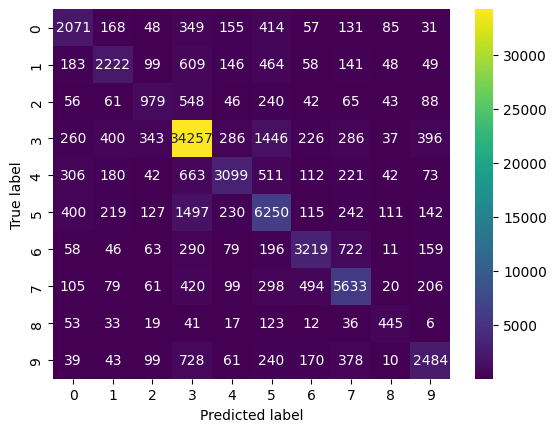

In [35]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### SGD Optimizer:

In [36]:
model_fineTuned_sgd = PoemNetwork()
model_fineTuned_sgd.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PoemNetwork(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [37]:
for param in model_fineTuned_sgd.bert.parameters():
    param.requires_grad = True

In [38]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(log_dir='MLP_Board')

learning_rate = 2e-5
# loss_fn = nn.BCEWithLogitsLoss(weight = weight.to(device))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fineTuned_sgd.parameters(), lr=learning_rate)

epochs = 5
for e in range(epochs):
    print(f" Epoch {e+1} -------------------------------")
    trainAcc, trainLoss = train_loop(e, train_dataloader, model_fineTuned_sgd, loss_fn, optimizer)
    # writer.add_scalar('Accuracy/train', trainAcc, e)
    # writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(test_dataloader, model_fineTuned_sgd, loss_fn, 'Test')
    # writer.add_scalar('Accuracy/validation', valAcc, e)
    # writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

 Epoch 1 -------------------------------


Epoch 1: 100%|██████████| 4970/4970 [05:02<00:00, 16.45batch/s, batch_accuracy=68.2, batch_loss=1.53]


 -Training Accuracy (Avg) = 44.9%, loss = 1.905715 

 -Test : Accuracy = 47.7%, Avg loss = 1.790296 

 Epoch 2 -------------------------------


Epoch 2: 100%|██████████| 4970/4970 [05:02<00:00, 16.43batch/s, batch_accuracy=40.9, batch_loss=1.99]


 -Training Accuracy (Avg) = 48.0%, loss = 1.779046 

 -Test : Accuracy = 47.7%, Avg loss = 1.775571 

 Epoch 3 -------------------------------


Epoch 3: 100%|██████████| 4970/4970 [05:02<00:00, 16.43batch/s, batch_accuracy=40.9, batch_loss=1.84]


 -Training Accuracy (Avg) = 48.0%, loss = 1.768955 

 -Test : Accuracy = 47.7%, Avg loss = 1.768104 

 Epoch 4 -------------------------------


Epoch 4: 100%|██████████| 4970/4970 [05:02<00:00, 16.43batch/s, batch_accuracy=40.9, batch_loss=1.94]


 -Training Accuracy (Avg) = 48.0%, loss = 1.762375 

 -Test : Accuracy = 47.7%, Avg loss = 1.761486 

 Epoch 5 -------------------------------


Epoch 5: 100%|██████████| 4970/4970 [05:02<00:00, 16.43batch/s, batch_accuracy=40.9, batch_loss=2]   


 -Training Accuracy (Avg) = 48.0%, loss = 1.755271 

 -Test : Accuracy = 47.7%, Avg loss = 1.752386 

Done!


In [39]:
y_pred = []
y_true = []

with torch.no_grad():
    for  (X, token, mask, label) in test_dataloader:
        X = X.to(device)
        mask = mask.to(device)
        label = label.to(device)
        pred = model_fineTuned_sgd(input_ids=X, attention_mask=mask)
        output = pred.argmax(1).cpu().numpy()
        y_pred.extend(output)
        label = label.cpu().numpy()
        y_true.extend(label)

In [40]:
print(classification_report(y_true=y_true,
                            y_pred=y_pred,
                            target_names=poet_name))

              precision    recall  f1-score   support

      khajoo       0.00      0.00      0.00      3509
        feyz       0.00      0.00      0.00      4019
      parvin       0.00      0.00      0.00      2168
       attar       0.48      1.00      0.65     37937
        seyf       0.00      0.00      0.00      5249
      khosro       0.00      0.00      0.00      9333
    farrokhi       0.00      0.00      0.00      4843
        amir       0.00      0.00      0.00      7415
    shahriar       0.00      0.00      0.00       785
 naserkhosro       0.00      0.00      0.00      4252

    accuracy                           0.48     79510
   macro avg       0.05      0.10      0.06     79510
weighted avg       0.23      0.48      0.31     79510



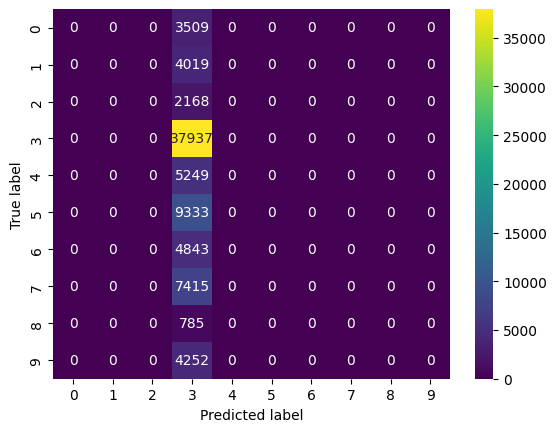

In [41]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Part 3 : Perplexity

In [42]:
dfSample = df.sample(1000)
tokenize_sample = tokenizer(dfSample['text'].tolist(), truncation=True, padding=True, max_length=256)
sample_dataset = PoemDataset(tokenize_sample, dfSample['label'].tolist())

sample_dataloader = DataLoader(sample_dataset, batch_size=64, shuffle=True)

In [43]:
loss_fn = nn.CrossEntropyLoss()
def metrics(dataloader, model, loss_fn):
    y_pred = []
    y_true = []
    loss = 0
    with torch.no_grad():
        for  (X, token, mask, label) in sample_dataloader:
            X = X.to(device)
            mask = mask.to(device)
            label = label.to(device)
            pred = model(input_ids=X, attention_mask=mask)

            loss += loss_fn(pred, label).item()

            output = pred.argmax(1).cpu().numpy()
            y_pred.extend(output)
            label = label.cpu().numpy()
            y_true.extend(label)
            
    return y_true, y_pred, loss

* without fine-tune (optimizer : adam)

In [44]:
true_fix, pred_fix, loss = metrics(sample_dataloader, model, loss_fn)
print("Perplexity : ", np.exp(loss/len(sample_dataloader.dataset)))

Perplexity :  1.023949677150349


* with fine-tune (optimizer : adam)

In [45]:
true_fix, pred_fix, loss = metrics(sample_dataloader, model_fineTuned_adam, loss_fn)
print("Perplexity : ", np.exp(loss/len(sample_dataloader.dataset)))

Perplexity :  1.004033723599279


* with fine-tune (optimizer : SGD)

In [46]:
true_fix, pred_fix, loss = metrics(sample_dataloader, model_fineTuned_sgd, loss_fn)
print("Perplexity : ", np.exp(loss/len(sample_dataloader.dataset)))

Perplexity :  1.0285279357840367


> Perplexity is usually used only to determine how well a model has learned the training set. as you can see, ***model that fine tuned worked better beacuase the perplexity is much lower than another model(without fine tuned)***. also, the `Adam` optimizer is better than `SGD` 